In [1]:
import os
import torch
import h5py
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.set_grad_enabled(False)
import open_clip
import pickle
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

In [2]:
# load the CLIP model

model, _, preprocess = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
model.cpu()
model.eval()
tokenizer = open_clip.get_tokenizer("ViT-H-14")

In [3]:
# load the ground truth bounding boxes

with open('/home/owenburns/vacc/outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

objects = ['apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda']
bboxes = {
    'apple': [(-0.7769833, 0.3524605, 0.15017936), (-0.68268924, 0.4545155, 0.2483119)],
    'banana': [(-0.37267345, 0.36484203, 0.15037148), (-0.13995615, 0.4852845, 0.19382282)],
    'milk': [(-0.0752123, 0.5250703, 0.15051995), (0.0596368, 0.62811373, 0.34507185)],
    'cereal': [(-0.1052123, 0.3250703, 0.15051995), (0.0396368, 0.40811373, 0.34507185)],
    'bin': [(0.0596368, 0.2750703, 0.15055764), (0.8581135, 0.707657, 0.2649597)]
}

# for object in objects:
#     object_points = outputs['xyz_pts'][outputs['segmentation_pts'][object]]
#     min_x = object_points[:, 0].min()
#     max_x = object_points[:, 0].max()
#     min_y = object_points[:, 1].min()
#     max_y = object_points[:, 1].max()
#     min_z = object_points[:, 2].min()
#     max_z = object_points[:, 2].max()
#     bboxes[object] = [(min_x, min_y, min_z), (max_x, max_y, max_z)]

In [4]:
# load the point cloud and features

SCENE_BOUNDS=((-1.4, -0.2, -0.1), (1.7, 1.2, 1.1))

xyz_pts = torch.load("/home/owenburns/vacc/xyz_pts.pt")
pixelwise_features = torch.load("/home/owenburns/vacc/clip_feaures.pt")
map_embeddings_norm = torch.nn.functional.normalize(pixelwise_features, dim=1).cpu()

In [74]:
# embed the search text

text = tokenizer(["box-shaped object"])
textfeat = model.encode_text(text.cpu())
textfeat = torch.nn.functional.normalize(textfeat, dim=-1)
textfeat = textfeat.unsqueeze(0)

In [75]:
# conduct the similarity search

cosine_similarity = torch.nn.CosineSimilarity(dim=-1).to('cpu')

# calculate the similarity between all of the pixel-level embeddings and the prompt, and scale it to the [0,1] range (normally [-1,1]) to serve as a colormap weight
similarity = cosine_similarity(
    map_embeddings_norm, textfeat
)

similarity_shifted = (similarity + 1.0) / 2.0 # shift the similarity to the [0,1] range

similarity_rel = (similarity_shifted - similarity_shifted.min()) / (
                similarity_shifted.max() - similarity_shifted.min() + 1e-12
            ) # normalize the similarity to the [0,1] range

similarity_rel_thresholded = similarity_rel.clone()

In [76]:
from scipy.spatial import KDTree
import numpy as np
# compute the IoU score

threshold = 0.98

similarity_rel_thresholded[similarity_rel_thresholded < threshold] = 0.0

# bounding_box = bboxes['bin']
def get_union_bbox(bboxes):
    bboxes_ = np.array(bboxes).reshape(-1, 6)
    return np.array([np.min(bboxes_[:, :3], axis=0), np.max(bboxes_[:, 3:], axis=0)])

bounding_box = get_union_bbox([bboxes['bin'], bboxes['cereal'], bboxes['milk']])

model_chosen_points = xyz_pts[similarity_rel_thresholded[0,:] >= threshold]

# get rid of outliers
radius_threshold = 0.1
min_neighbors = 50
tree = KDTree(model_chosen_points)

filtered_points = []
for point in model_chosen_points:
    neighbors = tree.query_ball_point(point, r=radius_threshold)
    if len(neighbors) >= min_neighbors:
        filtered_points.append(point)

model_chosen_points = torch.stack(filtered_points)

min_x = model_chosen_points[:, 0].min()
max_x = model_chosen_points[:, 0].max()
min_y = model_chosen_points[:, 1].min()
max_y = model_chosen_points[:, 1].max()
min_z = model_chosen_points[:, 2].min()
max_z = model_chosen_points[:, 2].max()
model_bounding_box = [(min_x, min_y, min_z), (max_x, max_y, max_z)]

def iou(boxA, boxB):
    xA = max(boxA[0][0], boxB[0][0])
    yA = max(boxA[0][1], boxB[0][1])
    zA = max(boxA[0][2], boxB[0][2])
    xB = min(boxA[1][0], boxB[1][0])
    yB = min(boxA[1][1], boxB[1][1])
    zB = min(boxA[1][2], boxB[1][2])

    # Compute the volume of the intersection cuboid
    interVolume = max(0, xB - xA) * max(0, yB - yA) * max(0, zB - zA)

    # Compute the volume of both the prediction and ground-truth cuboids
    boxAVolume = (boxA[1][0] - boxA[0][0]) * (boxA[1][1] - boxA[0][1]) * (boxA[1][2] - boxA[0][2])
    boxBVolume = (boxB[1][0] - boxB[0][0]) * (boxB[1][1] - boxB[0][1]) * (boxB[1][2] - boxB[0][2])

    # Compute the intersection over union by dividing the intersection volume by the union volume
    iou = interVolume / float(boxAVolume + boxBVolume - interVolume)

    # Return the 3D intersection over union value
    return iou

iou_score = iou(bounding_box, model_bounding_box)
print(iou_score)

tensor(0.5229)


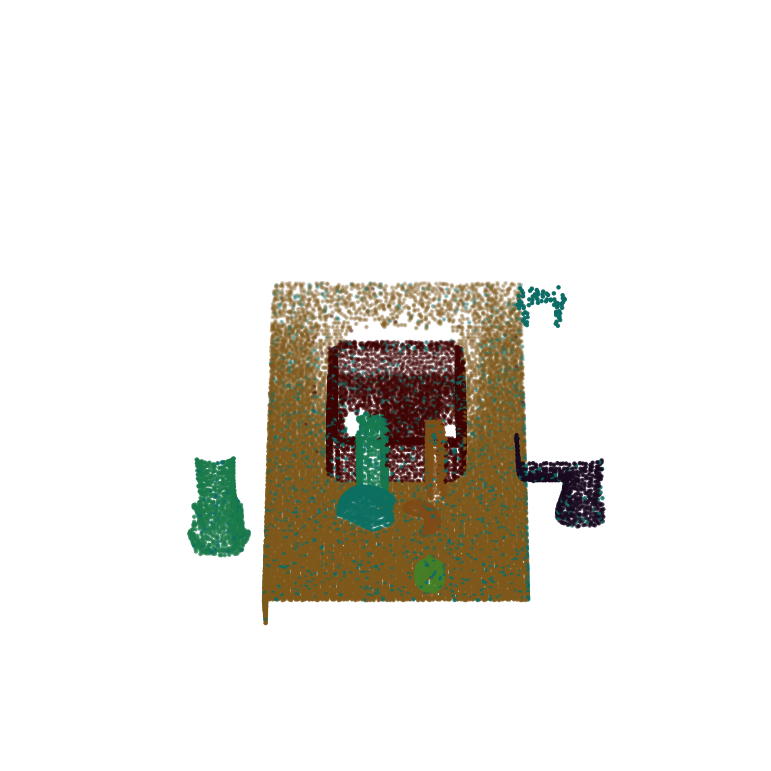

In [77]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import open3d as o3d

fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=50,azim=180)

cmap = colormaps.get_cmap('turbo')

similarity_colormap = cmap(similarity_rel[0].detach().cpu().numpy())[:, :3]
plot_colors = similarity_colormap * 0.5

# plot the point cloud
ax.scatter(
    xyz_pts[:, 0],
    xyz_pts[:, 1],
    xyz_pts[:, 2],
    c=plot_colors,
    s=1,  # type: ignore
)

# def get_corners(bbox):
#     min_point = bbox[0]
#     max_point = bbox[1]
#     corners = np.array([
#         [min_point[0], min_point[1], min_point[2]],
#         [min_point[0], max_point[1], min_point[2]],
#         [max_point[0], max_point[1], min_point[2]],
#         [max_point[0], min_point[1], min_point[2]],
#         [min_point[0], min_point[1], max_point[2]],
#         [min_point[0], max_point[1], max_point[2]],
#         [max_point[0], max_point[1], max_point[2]],
#         [max_point[0], min_point[1], max_point[2]],
#     ])
#     return corners

# def plot_wireframe_box(ax, corners, color="blue"):
#     # Define the edges of the box by connecting the corresponding corners
#     edges = [
#         [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
#         [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
#         [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
#     ]
#     for edge in edges:
#         ax.plot(
#             [corners[edge[0], 0], corners[edge[1], 0]],
#             [corners[edge[0], 1], corners[edge[1], 1]],
#             [corners[edge[0], 2], corners[edge[1], 2]],
#             color=color
#         )

# # # plot the model's bounding box
# model_corners = get_corners(model_bounding_box)
# plot_wireframe_box(ax, model_corners, color="darkviolet")

# # # plot the ground truth bounding box
# gt_corners = get_corners(bboxes['cereal'])
# plot_wireframe_box(ax, gt_corners, color="red")

# # Show the plot
# plt.legend(["Model's Bounding Box", "Ground Truth Bounding Box"])
ax.grid(False)
ax.set_axis_off()
plt.show()
# plt.close(fig)

In [32]:
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(xyz_pts)
point_cloud.colors = o3d.utility.Vector3dVector(plot_colors)

# Plot the bounding boxes
def create_bounding_box_points_and_lines(bbox, color):
    min_point = bbox[0]
    max_point = bbox[1]

    corners = np.array([
        [min_point[0], min_point[1], min_point[2]],
        [min_point[0], max_point[1], min_point[2]],
        [max_point[0], max_point[1], min_point[2]],
        [max_point[0], min_point[1], min_point[2]],
        [min_point[0], min_point[1], max_point[2]],
        [min_point[0], max_point[1], max_point[2]],
        [max_point[0], max_point[1], max_point[2]],
        [max_point[0], min_point[1], max_point[2]],
    ])

    # Create points and colors for the bounding box
    bbox_points = o3d.utility.Vector3dVector(corners)
    bbox_colors = o3d.utility.Vector3dVector([color for _ in range(corners.shape[0])])

    return bbox_points, bbox_colors

gt_bbox_points, gt_bbox_colors = create_bounding_box_points_and_lines(bounding_box, color=[1, 0, 0])  # Red color
model_bbox_points, model_bbox_colors = create_bounding_box_points_and_lines(model_bounding_box, color=[1, 1, 0])  # Yellow color

# Combine all points and colors
combined_points = np.vstack((np.asarray(point_cloud.points), np.asarray(gt_bbox_points), np.asarray(model_bbox_points), np.asarray(model_chosen_points)))#, np.asarray(outputs['xyz_pts'][outputs['segmentation_pts']["banana"]])))
combined_colors = np.vstack((np.asarray(point_cloud.colors), np.asarray(gt_bbox_colors), np.asarray(model_bbox_colors), np.array([[1,1,0]]*model_chosen_points.shape[0])))#, np.asarray(outputs['rgb_pts'][outputs['segmentation_pts']["banana"]]/255.0)))

# Create a new point cloud with combined points and colors
combined_point_cloud = o3d.geometry.PointCloud()
combined_point_cloud.points = o3d.utility.Vector3dVector(combined_points)
combined_point_cloud.colors = o3d.utility.Vector3dVector(combined_colors)

# Save the combined point cloud to a .ply file
o3d.io.write_point_cloud("colored_pointcloud_with_bboxes.ply", combined_point_cloud)

True